In [1]:
from PIL import Image
from bisect import bisect
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn import linear_model, preprocessing
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pathlib as pl
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

In [2]:
work_dir = pl.Path('data')
cygnss = pickle.load(open(work_dir / 'cygnss.pkl', 'rb'))
ddms = np.array(cygnss['ddm'])
lats = np.array(cygnss['lat_deg'])
lons = np.array(cygnss['lon_deg'])

In [3]:
target_file = work_dir / 'target.pkl'

if not target_file.exists():
    mask = np.array(Image.open(work_dir / 'water.tif'), dtype=np.uint8)
    mask[mask > 0] = 1
    wlons = np.linspace(extent[0], extent[1], mask.shape[1])
    wlats = np.linspace(extent[2], extent[3], mask.shape[0])
    ilons = [bisect(wlons, o) for o in lons]
    ilats = [mask.shape[0] - bisect(wlats, a) for a in lats]
    target = np.array([mask[a, o] for a, o in zip(ilats, ilons)])
    pickle.dump(target, open(target_file, 'wb'))
else:
    target = pickle.load(open(target_file, 'rb'))

In [4]:
# Remove negative values (-9999 is the invalid flag)
positive = np.array([i for i, d in enumerate(ddms) if np.all(d > 0)])
ddms = ddms[positive]
target = target[positive]
lats = lats[positive]
lons = lons[positive]
# Shuffle data together
ddms, target, lats, lons = shuffle(ddms, target, lats, lons, random_state=0)
ddms = ddms.reshape(ddms.shape[0], -1)

In [5]:
def make_map(background=False, coastline=0):
    """Create a plot for displaying samples geographically.

    :param background: Whether to add a terrain background image.
    :param coastline: The 'zorder' of the coastline (0 to omit)
    :returns: subplot
    :rtype: TODO

    """
    # Base
    fig, axes = plt.subplots()
    extent = (110, 120, 0, 10)
    axes.set_xlim([extent[0], extent[1]])
    axes.set_ylim([extent[2], extent[3]])
    yticks = [1, 3, 5, 7, 9]
    xticks = [111, 113, 115, 117, 119]
    axes.set_yticks(yticks)
    axes.set_xticks(xticks)
    axes.set_yticklabels([fr'{i}$^\circ$N' for i in yticks])
    axes.set_xticklabels([fr'{i}$^\circ$E' for i in xticks])
    axes.set_aspect('equal')

    # Coastline?
    if coastline != 0:
        img = mpimg.imread('images/coast.png').astype(int)
        zero = np.where(img == [0, 0, 0, 0])
        mask = np.full((img.shape[0], img.shape[1]), np.nan)
        mask[zero[0], zero[1]] = 1
        axes.imshow(mask,
                    origin='upper',
                    extent=extent,
                    zorder=coastline,
                    cmap=ListedColormap([(0, 0, 0, 1), (1, 1 ,1 ,1)]))

    # Background?
    if background:
        axes.imshow(mpimg.imread('images/blank_terrain.png'),
                    origin='upper',
                    extent=extent,
                    zorder=1,)

    return axes

In [6]:
def plot_ddm_stats(predictor, correct, water, land):
    ims = []
    ddm_water = predictor[water]
    ims.append(np.log10(np.mean(ddm_water, axis=0).reshape(17, 11)).copy())
    tpi = np.intersect1d(water, np.where(correct)[0])
    tpd = predictor[tpi]
    ims.append(np.log10(np.mean(tpd, axis=0).reshape(17, 11)).copy())
    fni = np.intersect1d(land, np.where(~correct)[0])
    fnd = predictor[fni]
    ims.append(np.log10(np.mean(fnd, axis=0).reshape(17, 11)).copy())
    fpi = np.intersect1d(water, np.where(~correct)[0])
    fpd = predictor[fpi]
    ims.append(np.log10(np.mean(fpd, axis=0).reshape(17, 11)).copy())
    tni = np.intersect1d(land, np.where(correct)[0])
    tnd = predictor[tni]
    ims.append(np.log10(np.mean(tnd, axis=0).reshape(17, 11)).copy())
    ddm_land = predictor[land]
    ims.append(np.log10(np.mean(ddm_land, axis=0).reshape(17, 11)).copy())
    titles = ['Positive', 'True Positive', 'False Positive', 'False Negative',
              'True Negative', 'Negative']
    fig, axes = plt.subplots(1, len(ims))
    for ax, im, ti in zip(axes, ims, titles):
        ax.set_yticks([])
        ax.set_xticks([])
        ax.set_title(ti, fontsize=7)
        ax.patch.set_visible(False)
        ax.imshow(im, cmap='jet', vmin=np.amin(ims[0]), vmax=np.amax(ims[0]))
    plt.tight_layout()

In [7]:
n = ddms.shape[0]
num_train = int(0.8 * n)
Xtr = ddms[:num_train]
ytr = target[:num_train]
Xts = ddms[num_train:]
yts = target[num_train:]
lats_ts = lats[num_train:]
lons_ts = lons[num_train:]
water_ts = np.where(yts == 1)[0]
land_ts = np.where(yts == 0)[0]

### Decision Tree

In [8]:
from sklearn.tree import DecisionTreeClassifier

# Make a decision tree and train
tree = DecisionTreeClassifier(random_state=50)

# Train tree
tree.fit(Xtr, ytr)
print(f'Decision tree has {tree.tree_.node_count} nodes with maximum depth {tree.tree_.max_depth}.')

Decision tree has 8463 nodes with maximum depth 59.


In [9]:
# Make probability predictions
train_probs = tree.predict_proba(Xtr)[:, 1]
probs = tree.predict_proba(Xts)[:, 1]

train_predictions = tree.predict(Xtr)
predictions = tree.predict(Xts)

In [10]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

print(f'Train ROC AUC Score: {roc_auc_score(ytr, train_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(yts, probs)}')

Train ROC AUC Score: 1.0
Test ROC AUC  Score: 0.8557320350053108


In [11]:
print(f'Baseline ROC AUC: {roc_auc_score(yts, [1 for _ in range(len(yts))])}')

Baseline ROC AUC: 0.5


### Evaluate the Decision Tree

In [12]:
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(yts, [1 for _ in range(len(yts))])
    baseline['precision'] = precision_score(yts, [1 for _ in range(len(yts))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(yts, predictions)
    results['precision'] = precision_score(yts, predictions)
    results['roc'] = roc_auc_score(yts, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(ytr, train_predictions)
    train_results['precision'] = precision_score(ytr, train_predictions)
    train_results['roc'] = roc_auc_score(ytr, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(yts, [1 for _ in range(len(yts))])
    model_fpr, model_tpr, _ = roc_curve(yts, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

In [13]:
from collections import Counter
print(Counter(probs))
print(Counter(predictions))

Counter({1.0: 12940, 0.0: 6585})
Counter({1: 12940, 0: 6585})


Recall Baseline: 1.0 Test: 0.91 Train: 1.0
Precision Baseline: 0.66 Test: 0.9 Train: 1.0
Roc Baseline: 0.5 Test: 0.86 Train: 1.0


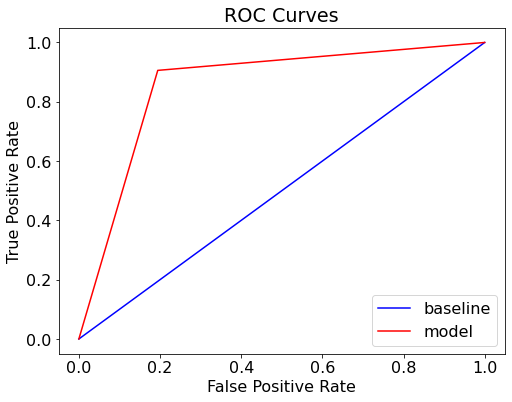

In [14]:
evaluate_model(predictions, probs, train_predictions, train_probs)

### Confusion Matrix of Decision Tree

In [15]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 12)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 10)
    plt.yticks(tick_marks, classes, size = 10)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 10,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 10)
    plt.xlabel('Predicted label', size = 10)

Confusion matrix, without normalization
[[ 5375  1297]
 [ 1210 11643]]


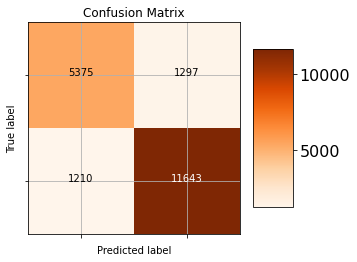

In [16]:
cm = confusion_matrix(yts, predictions)
plot_confusion_matrix(cm, classes = ['', ''],
                      title = 'Confusion Matrix')

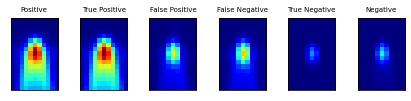

In [17]:
correct = predictions.astype(int) == yts
plot_ddm_stats(Xts, correct, water_ts, land_ts)
plt.show()
plt.close()

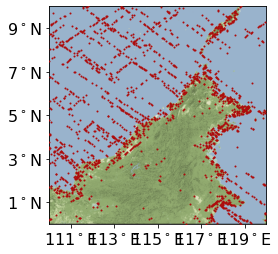

In [37]:
axes = make_map(background=True)
axes.scatter(lons_ts[~correct], lats_ts[~correct], s=1, c='#ad0c0c', zorder=4)
plt.show()
plt.close()

### Random Forest Optimization through Random Search

In [19]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

# Hyperparameter grid
param_grid = {
    'n_estimators': np.linspace(10, 200).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

# Estimator for use in random search
estimator = RandomForestClassifier(random_state = 50)

# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 3, 
                        n_iter = 10, verbose = 1, random_state=50)

# Fit 
rs.fit(Xtr, ytr)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 31.5min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=50),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 3, 3, 3, 4, 4, 4, 5,
                                                      5, 5, 6, 6, 6, 7, 7, 7, 8,
                                                      8, 8, 9, 9, 9, 10, 10, 10,
                                                      11, 11, 12, 12, 12, ...],
                                        'max_features': ['auto', 'sqrt', None,
                                                         0.5, 0.6, 0.7,
                                                         0.7999999999999999,
                                                         0.8999999999999999],
                                        'max_leaf_nodes': [None, 10, 10, 10, 10,
                                                           10, 10, 10, 10, 10,
                                     

In [20]:
rs.best_params_

{'n_estimators': 29,
 'min_samples_split': 5,
 'max_leaf_nodes': 43,
 'max_features': 'auto',
 'max_depth': 16,
 'bootstrap': True}

### Use Best Model of Random Forest  

In [21]:
best_model = rs.best_estimator_

In [22]:
train_rf_predictions = best_model.predict(Xtr)
train_rf_probs = best_model.predict_proba(Xtr)[:, 1]

rf_predictions = best_model.predict(Xts)
rf_probs = best_model.predict_proba(Xts)[:, 1]

In [35]:
acc_train = np.mean(train_rf_predictions == ytr)
acc = np.mean(rf_predictions == yts)
print('Accuracy on train data = {0:.4f}'.format(acc_train))
print('Accuracy on test data = {0:.4f}'.format(acc))

Accuracy on train data = 0.8989
Accuracy on test data = 0.8981


In [29]:
n_nodes = []
max_depths = []

for ind_tree in best_model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')


Average number of nodes 85
Average maximum depth 8


Recall Baseline: 1.0 Test: 0.92 Train: 0.92
Precision Baseline: 0.66 Test: 0.93 Train: 0.93
Roc Baseline: 0.5 Test: 0.95 Train: 0.95


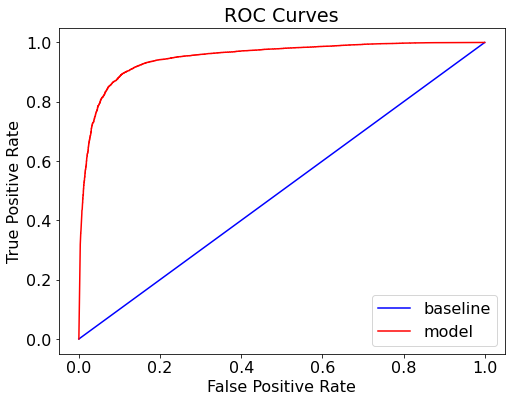

In [30]:
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)

Confusion matrix, without normalization
[[ 5747   925]
 [ 1065 11788]]


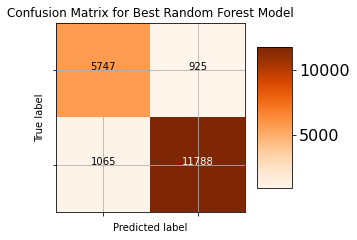

In [36]:
cm = confusion_matrix(yts, rf_predictions)
plot_confusion_matrix(cm, classes = ['', ''],
                      title = 'Confusion Matrix for Best Random Forest Model')

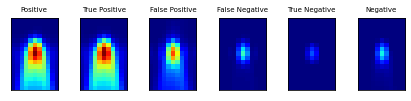

In [32]:
correct = rf_predictions.astype(int) == yts
plot_ddm_stats(Xts, correct, water_ts, land_ts)
plt.show()
plt.close()

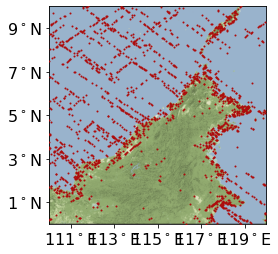

In [27]:
axes = make_map(background=True)
axes.scatter(lons_ts[~correct], lats_ts[~correct], s=1, c='#ad0c0c', zorder=4)
plt.show()
plt.close()

In [33]:
#Save the model
import pickle
file_name = 'random_best.sav'
pickle.dump(best_model,open(file_name,'wb'))